## Importing packages

Substituir output por lista de None

In [1]:
import io
import requests
import os
import sys
import math
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import random
import copy
import multiprocessing as mp
%matplotlib inline

from programs.functions import *
from programs.sklearn_models import *
from programs.w_models import *
from programs.select_vars_gmm import *
from programs.dataset_functions import *

In [2]:
random.seed(42)
np.random.seed(42)

## Setting up datasets

Downloading datasets

In [3]:
dataset_names=['abalone','ailerons','bank32nh','cal_housing','cpu_act','delta_ailerons',
               'elevators', 'fried_delve','puma32H', 'winequality' ] 

In [4]:
data={}
for name in dataset_names: data[name]=download_dataset(name) #get_X_y(, scale=True)

- *** abalone *** dataset shape= (4177, 9)
- *** ailerons *** dataset shape= (13750, 41)
- *** bank32nh *** dataset shape= (8192, 34)
- *** cal_housing *** dataset shape= (20640, 9)
- *** cpu_act *** dataset shape= (8192, 22)
- *** delta_ailerons *** dataset shape= (7129, 6)
- *** elevators *** dataset shape= (16599, 19)
- *** fried_delve *** dataset shape= (40768, 11)
- *** puma32H *** dataset shape= (8192, 33)
- *** winequality *** dataset shape= (6497, 12)


In [5]:
for name in dataset_names: 
    n = data[name].shape[0]
    index = np.random.choice(n, min(8000,n), replace=False)
    data[name]=data[name].iloc[index,:]

As we are going to work only with continous features, then we remove the categorical features:

In [6]:
#Excluindo variável categórica
data['abalone']=data['abalone'].iloc[:,1:]

Get X and y:

In [7]:
for name in dataset_names: data[name]=get_X_y(data[name], scale=False) #

Expanding X

In [8]:
for name in dataset_names:
    n,d=data[name][0].shape
    
    if d<40:
        data[name][0]=np.hstack((data[name][0], np.random.normal(0,1,n*(32-d)).reshape((n,-1))))

In [9]:
for name in dataset_names:
    m=np.median(data[name][1])
    data[name][1]=1*(data[name][1]>m)

In [10]:
from sklearn.preprocessing import StandardScaler

for name in dataset_names: 
    scaler=StandardScaler()
    data[name][0]=scaler.fit_transform(data[name][0])
    print(name,data[name][0].shape)

abalone (4177, 32)
ailerons (8000, 40)
bank32nh (8000, 32)
cal_housing (8000, 32)
cpu_act (8000, 32)
delta_ailerons (7129, 32)
elevators (8000, 32)
fried_delve (8000, 32)
puma32H (8000, 32)
winequality (6497, 32)


Splitting data

In [11]:
B=75

In [12]:
%%time
BB=2*B*48
output={}

for name in dataset_names: 
    print("***",name,"***")
    pool = mp.Pool(40)
    output[name] = pool.starmap(aval_class, [(b, data[name][0], data[name][1]) for b in range(BB)]) #starmap
    pool.close()

*** abalone ***
*** ailerons ***
*** bank32nh ***
*** cal_housing ***
*** cpu_act ***
*** delta_ailerons ***
*** elevators ***
*** fried_delve ***
*** puma32H ***
*** winequality ***
CPU times: user 21 s, sys: 55.8 s, total: 1min 16s
Wall time: 1h 22min 18s



************ abalone ************
Relative Error


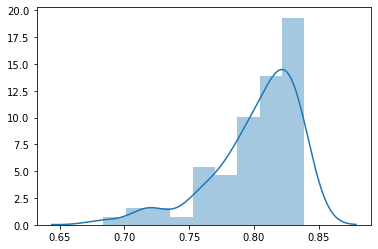


ESS (%)


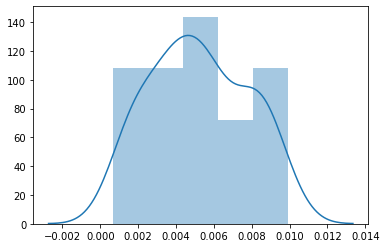


ESS (n)


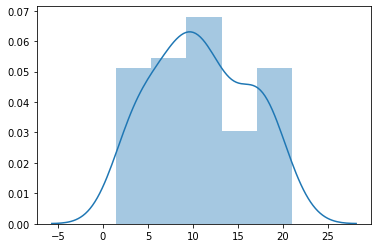


Max w


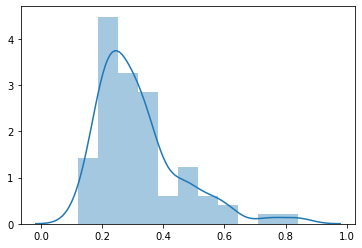


Actual training sample size


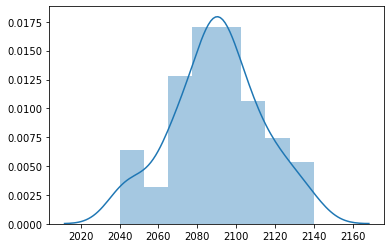


************ ailerons ************
Relative Error


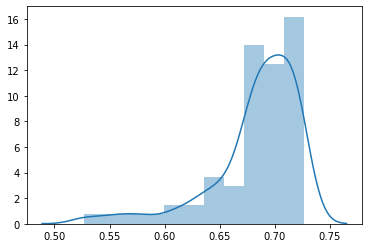


ESS (%)


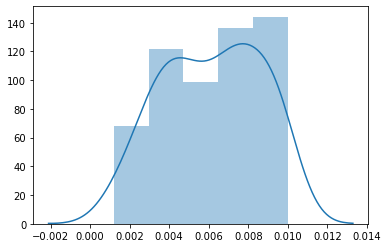


ESS (n)


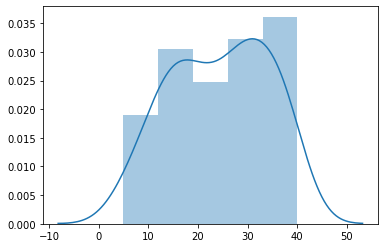


Max w


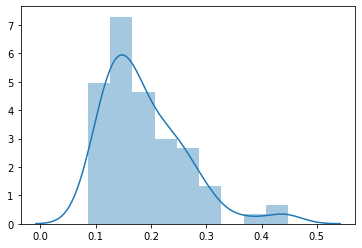


Actual training sample size


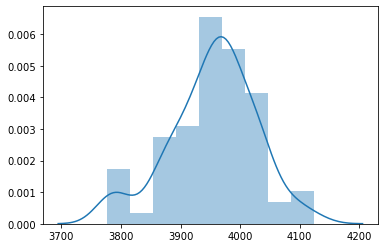


************ bank32nh ************
Relative Error


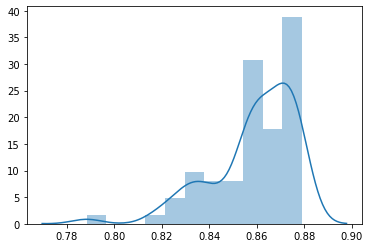


ESS (%)


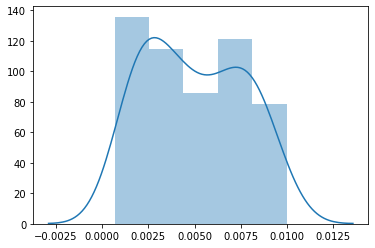


ESS (n)


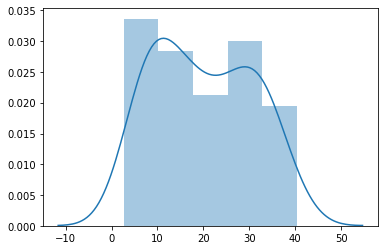


Max w


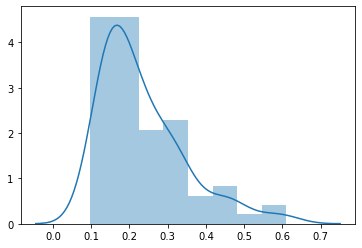


Actual training sample size


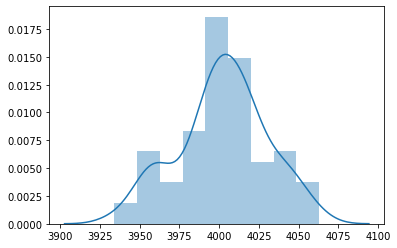


************ cal_housing ************
Relative Error


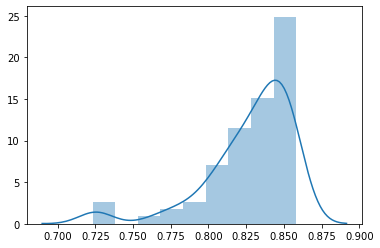


ESS (%)


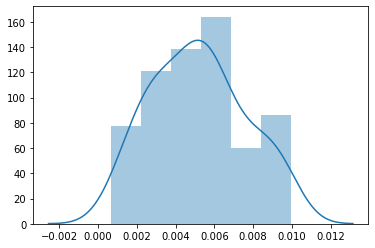


ESS (n)


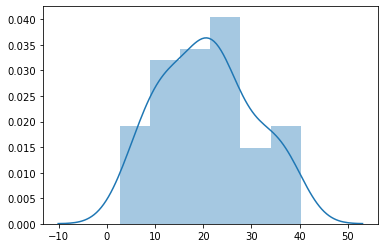


Max w


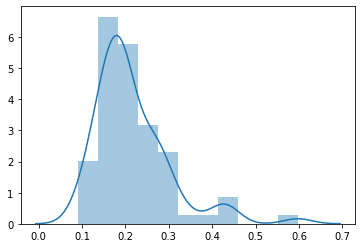


Actual training sample size


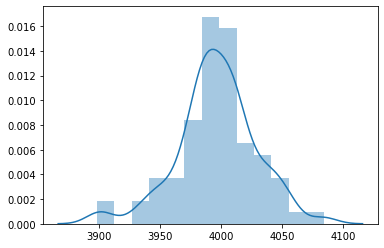


************ cpu_act ************
Relative Error


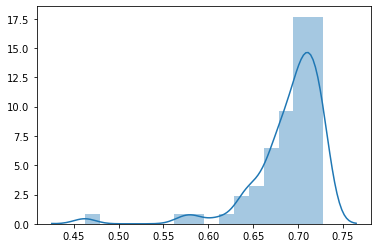


ESS (%)


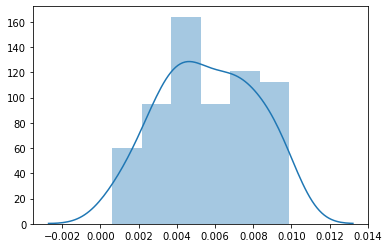


ESS (n)


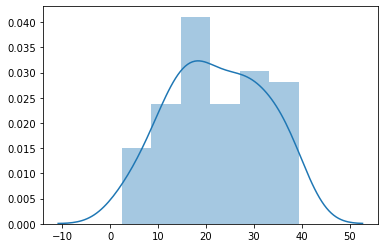


Max w


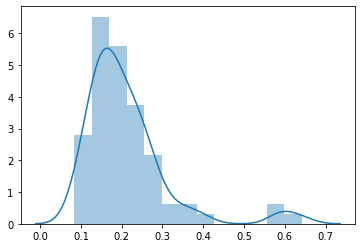


Actual training sample size


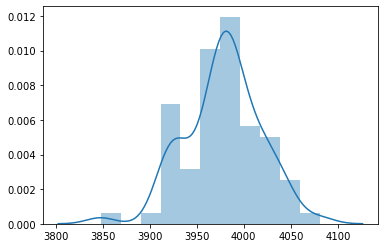


************ delta_ailerons ************
Relative Error


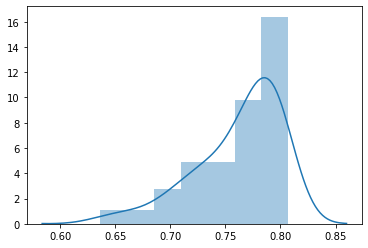


ESS (%)


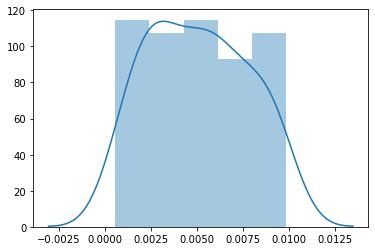


ESS (n)


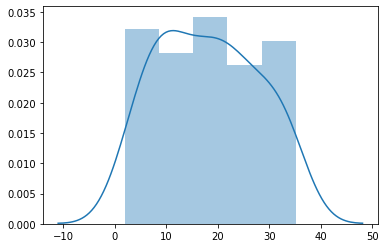


Max w


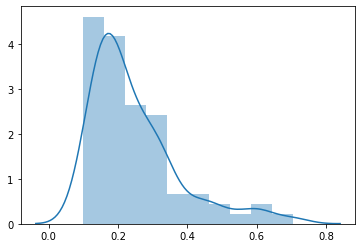


Actual training sample size


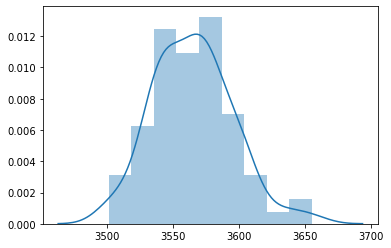


************ elevators ************
Relative Error


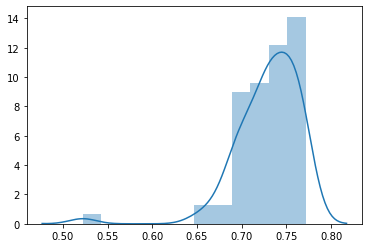


ESS (%)


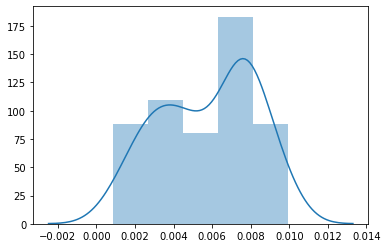


ESS (n)


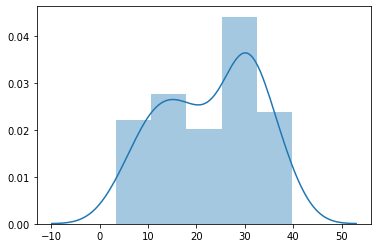


Max w


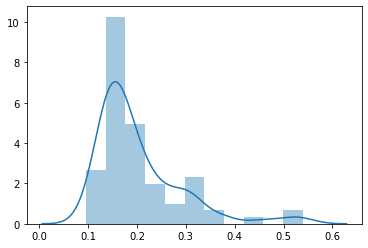


Actual training sample size


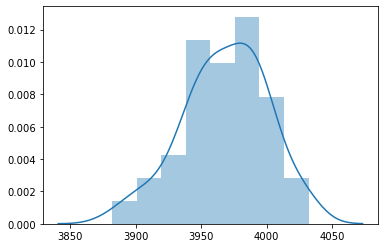


************ fried_delve ************
Relative Error


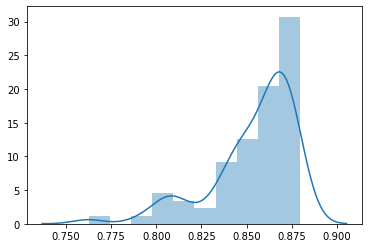


ESS (%)


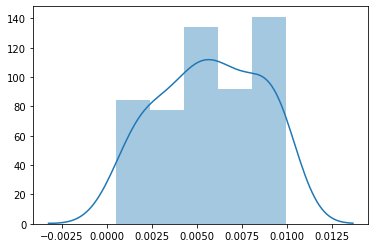


ESS (n)


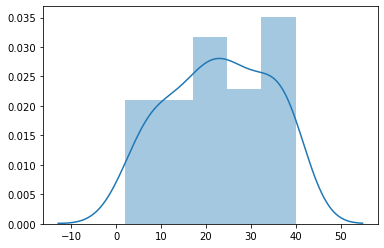


Max w


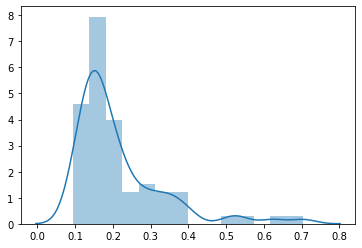


Actual training sample size


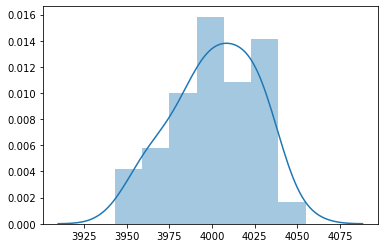


************ puma32H ************
Relative Error


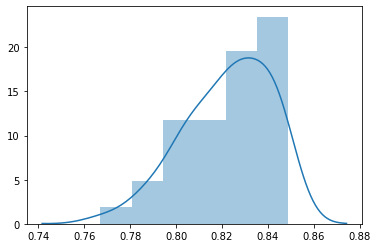


ESS (%)


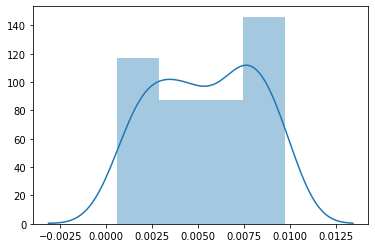


ESS (n)


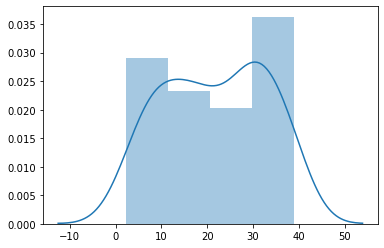


Max w


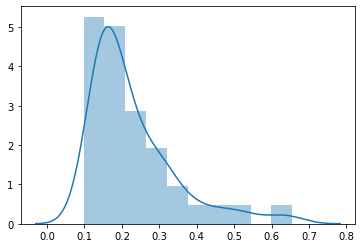


Actual training sample size


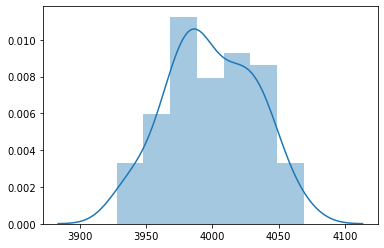


************ winequality ************
Relative Error


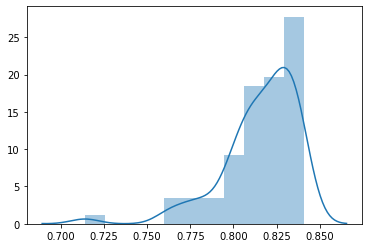


ESS (%)


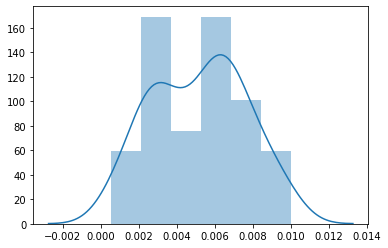


ESS (n)


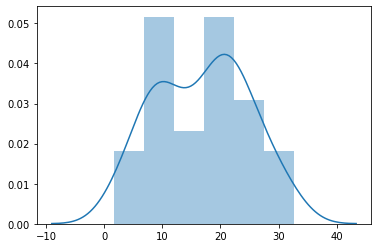


Max w


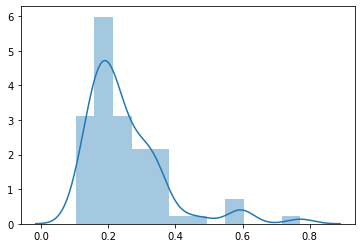


Actual training sample size


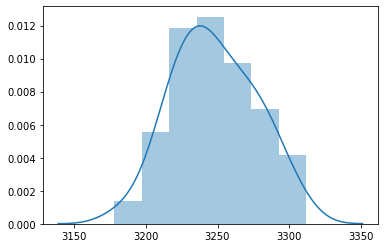

CPU times: user 11.8 s, sys: 1.23 s, total: 13 s
Wall time: 27.3 s


In [13]:
%%time

data_split={}

###     
for name in dataset_names: 
    
    arr=np.array(output[name])
    index_sort=arr[:,0].argsort()
    data_split[name]={}
    
    ###
    error_ratios=[]
    ess_percs=[]
    ess_ns=[]
    w_maxs=[]
    ns=[]
    
    ###
    for b in range(B):

        error_ratio=arr[index_sort[b]][0]
        ess_perc=arr[index_sort[b]][1]
        ess_n=arr[index_sort[b]][2] 
        n=arr[index_sort[b]][3]
        s=arr[index_sort[b]][4]
        w=arr[index_sort[b]][5]
        data_split[name][b]={}

        data_split[name][b]['train']=data[name][0][s], data[name][1][s], w[s]
        data_split[name][b]['test']=data[name][0][~s], data[name][1][~s], w[~s]
        
        error_ratios.append(error_ratio)
        ess_percs.append(ess_perc)
        ess_ns.append(ess_n)
        w_maxs.append(np.max(w[s])/np.sum(w[s]))
        ns.append(n)
        
    
    print("\n************",name,"************")
    print("Relative Error")
    sns.distplot(error_ratios)
    plt.show()
    
    print("\nESS (%)")
    sns.distplot(ess_percs)
    plt.show()
    
    print("\nESS (n)")
    sns.distplot(ess_ns)
    plt.show()
    
    print("\nMax w")
    sns.distplot(w_maxs)
    plt.show()
    
    print("\nActual training sample size")
    sns.distplot(ns)
    plt.show()

## Experiments

Some of the experiments will be created but will carry no content. This is because we wanted to keep the same structure for the notebook compared to its older versions.

### All features - true weights

In [14]:
def experiments_true(b):
    
    #Datasets
    X_test, y_test=copy.deepcopy(data_split[name][b]['test'][0]), copy.deepcopy(data_split[name][b]['test'][1])
    X_train, y_train=copy.deepcopy(data_split[name][b]['train'][0]),copy.deepcopy(data_split[name][b]['train'][1])
    X_test, X_test_w, y_test, y_test_w=train_test_split(X_test, y_test, test_size=0.8, random_state=42) #the greater percentage goes to w training
    
    #####################################
    ######## Weighted Experiment ########
    #####################################

    #Estimate w
    w = copy.deepcopy(data_split[name][b]['train'][2])
    
    #Training
    w_norm=w/np.sum(w)
    w_norm1=copy.deepcopy(w_norm)
    model1 = DT_class()
    model1 = model1.fit(X_train,y_train,sample_weight=w_norm)
    
    #Testing
    y_hat1 = model1.predict(X_test)
    error1 = class_error(y_hat1,y_test)
    
    #W_MAX
    n=w.shape[0]
    index = w.argsort()[-int(n/100):][::-1]
    w_10_1 = np.sum(w_norm[index])/np.sum(w_norm)

    #ESS
    n=w.shape[0]
    ess1=np.round(1/np.sum(w_norm**2), 2) 

    #Output
    return None, [b, error1, w_10_1, ess1/n, X_train.shape[1], w_norm1], [b, None, None, None, None, None]

In [15]:
%%time 
output={}

for name in dataset_names: 
    print("***",name,"***")

    pool = mp.Pool(mp.cpu_count())
    output[name] = pool.map_async(experiments_true, [(b) for b in range(B)]).get()
    pool.close()

*** abalone ***
*** ailerons ***
*** bank32nh ***
*** cal_housing ***
*** cpu_act ***
*** delta_ailerons ***
*** elevators ***
*** fried_delve ***
*** puma32H ***
*** winequality ***
CPU times: user 2.42 s, sys: 2min 11s, total: 2min 14s
Wall time: 2min 29s


In [16]:
experiments_true1_output={}
experiments_true2_output={}

for name in dataset_names: 
    experiments_true1_output[name]=[] 
    experiments_true2_output[name]=[]
    
    for b in range(B):
        experiments_true1_output[name].append(output[name][b][1][:-1])
        experiments_true2_output[name].append(output[name][b][2][:-1])
         
    experiments_true1_output[name]=np.array(experiments_true1_output[name])
    experiments_true2_output[name]=np.array(experiments_true2_output[name])

In [17]:
f = open("outputs/experiments_true1_output_class.pkl","wb")
pickle.dump(experiments_true1_output,f)
f.close()

f = open("outputs/experiments_true2_output_class.pkl","wb")
pickle.dump(experiments_true2_output,f)
f.close()

### All features - estimated weights

In [18]:
def experiments_0_1_2(b):
    
    #Datasets
    X_test, y_test=copy.deepcopy(data_split[name][b]['test'][0]), copy.deepcopy(data_split[name][b]['test'][1])
    X_train, y_train=copy.deepcopy(data_split[name][b]['train'][0]),copy.deepcopy(data_split[name][b]['train'][1])
    X_test, X_test_w, y_test, y_test_w=train_test_split(X_test, y_test, test_size=0.8, random_state=42) #the greater percentage goes to w training
   
    
    #####################################
    ####### Unweighted Experiment #######
    #####################################
    
    #Training
    model0=DT_class()
    model0=model0.fit(X_train,y_train,sample_weight=None)
    
    #Testing
    y_hat0=model0.predict(X_test)
    error0=class_error(y_hat0,y_test)
    
    
    #####################################
    ######## Weighted Experiment ########
    #####################################

    #Estimate w
    model_w = Poly_Logreg_w(2) 
    model_w.fit(X_test_w, X_train)
    w = model_w.predict(X_train)
    
    #Training
    w_norm=w/np.sum(w)
    w_norm1=copy.deepcopy(w_norm)
    model1 = DT_class()
    model1 = model1.fit(X_train,y_train,sample_weight=w_norm)
    
    #Testing
    y_hat1 = model1.predict(X_test)
    error1 = class_error(y_hat1,y_test)
    
    #W_MAX
    n=w.shape[0]
    index = w.argsort()[-int(n/100):][::-1]
    w_10_1 = np.sum(w_norm[index])/np.sum(w_norm)

    #ESS
    n=w.shape[0]
    ess1=np.round(1/np.sum(w_norm**2), 2) 
    
    
    #Output
    return [b, error0, .01 , 1, X_train.shape[1], None], [b, error1, w_10_1, ess1/n, X_train.shape[1], w_norm1], [b, None, None, None, None, None]

In [19]:
%%time 
output={}

for name in dataset_names: 
    print("***",name,"***")

    pool = mp.Pool(mp.cpu_count())
    output[name] = pool.map_async(experiments_0_1_2, [(b) for b in range(B)]).get()
    pool.close()

*** abalone ***
*** ailerons ***
*** bank32nh ***
*** cal_housing ***
*** cpu_act ***
*** delta_ailerons ***
*** elevators ***
*** fried_delve ***
*** puma32H ***
*** winequality ***
CPU times: user 3.16 s, sys: 2min 7s, total: 2min 10s
Wall time: 9min 29s


In [20]:
experiments_0_output={}
experiments_1_output={}
experiments_2_output={}

for name in dataset_names: 
    experiments_0_output[name]=[]
    experiments_1_output[name]=[] 
    experiments_2_output[name]=[]
    
    for b in range(B):
        experiments_0_output[name].append(output[name][b][0][:-1])
        experiments_1_output[name].append(output[name][b][1][:-1])
        experiments_2_output[name].append(output[name][b][2][:-1])
        
    experiments_0_output[name]=np.array(experiments_0_output[name])
    experiments_1_output[name]=np.array(experiments_1_output[name])
    experiments_2_output[name]=np.array(experiments_2_output[name])

In [21]:
f = open("outputs/experiments_0_output_class.pkl","wb")
pickle.dump(experiments_0_output,f)
f.close()

f = open("outputs/experiments_1_output_class.pkl","wb")
pickle.dump(experiments_1_output,f)
f.close()

f = open("outputs/experiments_2_output_class.pkl","wb")
pickle.dump(experiments_2_output,f)
f.close()

### Selected features - estimated weights

In [22]:
def gmm_scores(X_train,X_test,k):  
    clf = mixture.GaussianMixture(n_components=k, covariance_type='full')
    clf.fit(X_train)
    return [clf.score(X_test),clf.aic(X_test), clf.bic(X_test)]

In [23]:
def experiments_3_4_5(b):

    #Datasets
    X_test, y_test=copy.deepcopy(data_split[name][b]['test'][0]), copy.deepcopy(data_split[name][b]['test'][1])
    X_train, y_train=copy.deepcopy(data_split[name][b]['train'][0]),copy.deepcopy(data_split[name][b]['train'][1])
    X_test, X_test_w, y_test, y_test_w=train_test_split(X_test, y_test, test_size=0.8, random_state=42) #the greater percentage goes to w training
    
    #GMM
    classes=list(set(y_train))
    gmm={}

    for c in classes:
        #Selecting number of components
        X_gmm_train, X_gmm_test, _, _=train_test_split(X_train[y_train==c], X_train[y_train==c], test_size=0.5, random_state=42)
        aic_bic=np.array([gmm_scores(X_gmm_train, X_gmm_test, k) for k in list(range(1,15,2))])
        k_star=2*np.argmax(aic_bic[:,0])+1

        #Training GMMs
        gmm[c] = mixture.GaussianMixture(n_components=k_star, covariance_type='full', random_state=42)
        gmm[c].fit(X_train[y_train==c])

    #Selecting vars
    select=select_vars(gmm, d=15, stop=0.01)
    select.fit(X_train, y_train, verbose=False)    
    X_train=select.transform(X_train)
    X_test=select.transform(X_test)
    X_test_w=select.transform(X_test_w)
    
    
    #####################################
    ######## Weighted Experiment ########
    #####################################

    #Estimate w
    model_w = Poly_Logreg_w(2) 
    model_w.fit(X_test_w, X_train)
    w = model_w.predict(X_train)
    
    #Training
    w_norm=w/np.sum(w)
    w_norm1=copy.deepcopy(w_norm)
    model1 = DT_class()
    model1 = model1.fit(X_train,y_train,sample_weight=w_norm)
    
    #Testing
    y_hat1 = model1.predict(X_test)
    error1 = class_error(y_hat1,y_test)
    
    #W_MAX
    n=w.shape[0]
    index = w.argsort()[-int(n/100):][::-1]
    w_10_1 = np.sum(w_norm[index])/np.sum(w_norm)

    #ESS
    n=w.shape[0]
    ess1=np.round(1/np.sum(w_norm**2), 2) 
    
    #Output
    return [b, None, None, None, None, None], [b, error1, w_10_1, ess1/n, X_train.shape[1],w_norm1], [b, None, None, None, None, None]

In [24]:
%%time 
output={}

for name in dataset_names: 
    print("***",name,"***")

    pool = mp.Pool(mp.cpu_count())
    output[name] = pool.map_async(experiments_3_4_5, [(b) for b in range(B)]).get()
    pool.close()

*** abalone ***
*** ailerons ***
*** bank32nh ***
*** cal_housing ***
*** cpu_act ***
*** delta_ailerons ***
*** elevators ***
*** fried_delve ***
*** puma32H ***
*** winequality ***
CPU times: user 3.47 s, sys: 2min 23s, total: 2min 27s
Wall time: 5h 58min 21s


In [25]:
experiments_3_output={}
experiments_4_output={}
experiments_5_output={}

for name in dataset_names: 
    experiments_3_output[name]=[] 
    experiments_4_output[name]=[]
    experiments_5_output[name]=[]
    
    for b in range(B):
        experiments_3_output[name].append(output[name][b][0][:-1])
        experiments_4_output[name].append(output[name][b][1][:-1])
        experiments_5_output[name].append(output[name][b][2][:-1])
    
        
    experiments_3_output[name]=np.array(experiments_3_output[name])
    experiments_4_output[name]=np.array(experiments_4_output[name])
    experiments_5_output[name]=np.array(experiments_5_output[name])

In [26]:
f = open("outputs/experiments_3_output_class.pkl","wb")
pickle.dump(experiments_3_output,f)
f.close()

f = open("outputs/experiments_4_output_class.pkl","wb")
pickle.dump(experiments_4_output,f)
f.close()

f = open("outputs/experiments_5_output_class.pkl","wb")
pickle.dump(experiments_5_output,f)
f.close()